In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

# Import data 

In [2]:
data = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv',encoding='ISO-8859-1')

In [3]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


# **Data Cleaning**

In [5]:
data=data[['v1','v2']].copy()

In [6]:
data.rename(columns={'v1':'class','v2':'text'},inplace=True)

In [7]:
data['target']=data['class'].map({'ham':0 ,'spam':1})

In [8]:
new_data=data[['target','text']]

In [9]:
# dublicate values
new_data.duplicated().sum()

403

In [10]:
new_data.drop_duplicates(inplace=True)

/tmp/ipykernel_19/3898862419.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data.drop_duplicates(inplace=True)


In [11]:
new_data.duplicated().sum()

0

In [12]:
new_data

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


# Visualization 

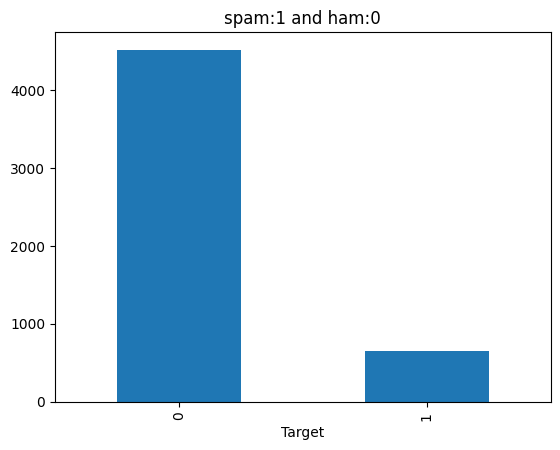

In [13]:
new_data['target'].value_counts().plot(kind='bar')
plt.xlabel('Target')
plt.title('spam:1 and ham:0')
plt.show()

* 1 is spam 
* 0 is ham 
* data is imbalance

# **Text Data Preprocessing**
* Lower case
*Tokenization
*Remove special characters 
*removing stop words and punctuaction
*stemming

In [14]:
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
import string

In [15]:
ps=PorterStemmer()

#### Function for transformation Text

In [16]:
def transform_data(data):
    data = data.lower()
    data= nltk.word_tokenize(data)
    
    y=[]
    for i in data:
        if i.isalnum():
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words("english") and i not in string.punctuation:
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
            
    return " ".join(y)

In [17]:
transform_data("hello guys I am ziad")

'hello guy ziad'

In [18]:
new_data['transformed_txt']=new_data.text.apply(transform_data)

/tmp/ipykernel_19/1073675367.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['transformed_txt']=new_data.text.apply(transform_data)


In [19]:
spam_corpus = []
for msg in new_data[new_data['target']==1]['transformed_txt'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [20]:
len(spam_corpus)

9883

In [21]:
from collections import Counter
Counter(spam_corpus).most_common(15)

[('call', 320),
 ('free', 189),
 ('2', 155),
 ('txt', 141),
 ('text', 122),
 ('u', 119),
 ('ur', 119),
 ('mobil', 114),
 ('stop', 104),
 ('repli', 103),
 ('claim', 98),
 ('prize', 82),
 ('4', 76),
 ('get', 74),
 ('new', 64)]

In [22]:
ham_corpus = []
for msg in new_data[new_data['target']==0]['transformed_txt'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

In [23]:
len(ham_corpus)

34771

# **Model**

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
cv= CountVectorizer()

In [25]:
new_data.reset_index(inplace=True)

In [26]:
X = cv.fit_transform(new_data['transformed_txt']).toarray()
y=new_data['target'].values

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix ,precision_score , recall_score
params={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
gs=GridSearchCV(log_clf,params,cv=3,verbose=3)
gs.fit(X_train,y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits
[CV 1/3] END .................C=0.001, penalty=l1;, score=nan total time=   0.1s
[CV 2/3] END .................C=0.001, penalty=l1;, score=nan total time=   0.1s
[CV 3/3] END .................C=0.001, penalty=l1;, score=nan total time=   0.1s
[CV 1/3] END ...............C=0.001, penalty=l2;, score=0.877 total time=   0.4s
[CV 2/3] END ...............C=0.001, penalty=l2;, score=0.877 total time=   0.4s
[CV 3/3] END ...............C=0.001, penalty=l2;, score=0.877 total time=   0.4s
[CV 1/3] END ..................C=0.01, penalty=l1;, score=nan total time=   0.1s
[CV 2/3] END ..................C=0.01, penalty=l1;, score=nan total time=   0.1s
[CV 3/3] END ..................C=0.01, penalty=l1;, score=nan total time=   0.1s
[CV 1/3] END ................C=0.01, penalty=l2;, score=0.885 total time=   0.4s
[CV 2/3] END ................C=0.01, penalty=l2;, score=0.890 total time=   0.4s
[CV 3/3] END ................C=0.01, penalty=l2;

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
21 fits failed out of a total of 42.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000, random_state=42),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             verbose=3)

In [29]:
gs.best_score_

0.977750962761977

In [30]:
gs.best_params_

{'C': 100.0, 'penalty': 'l2'}

In [31]:
y_pred=gs.predict(X_test)


## Evaluation

In [32]:

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 99.22%
Recall: 88.28%


In [33]:
cm=confusion_matrix(y_test,y_pred)
cm

array([[888,   1],
       [ 17, 128]])

## Confusion matrix 

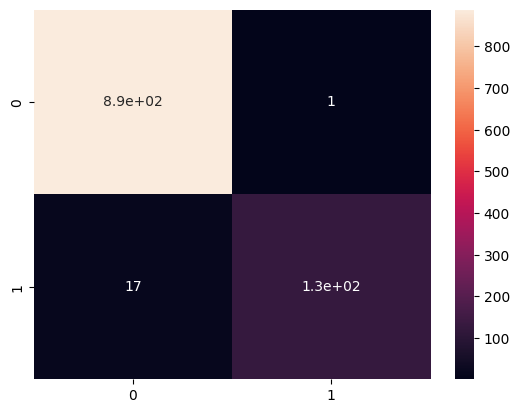

In [34]:

sns.heatmap(cm,annot=True)
plt.show()